In [1]:
from google.colab import files
uploaded = files.upload()

Saving Wholesale customers data.csv to Wholesale customers data.csv


# Wholesale Customer Segmentation: Identifying Purchasing Patterns with Clustering
The goal of this project is to segment wholesale customers based on their purchasing behavior.
Since we do not have predefined customer groups, we apply clustering techniques to discover meaningful patterns in the data.
Clustering is an appropriate technique here because it allows us to group similar customers together without predefined labels.
Understanding these segments can help businesses tailor marketing strategies and optimize resource allocation.

github: https://github.com/MFranco2000/effective-octo-palm-tree

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Data Collection and Provenance
The dataset used in this project is the Wholesale Customers Dataset from the UCI Machine Learning Repository.
This dataset contains annual spending amounts of customers on different product categories.
The data was originally collected from clients of a wholesale distributor.
It includes 440 samples with six features: Fresh, Milk, Grocery, Frozen, Detergents_Paper, and Delicatessen.
The goal of this dataset is to analyze customer purchasing behavior and identify distinct groups.

Citation: Cardoso, M. (2013). Wholesale customers [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5030X.

First, I load in the dataset, get some basic information and summary statistics, and then check for missing values.

In [3]:
# Load the dataset
df = pd.read_csv('Wholesale customers data.csv')

# Display first few rows
display(df.head())

# Basic info and summary statistics
print("\nDataset Information:")
df.info()
print("\nSummary Statistics:")
display(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Dropping Unnecessary Columns
df = df.drop('Channel', axis=1)
df = df.drop('Region', axis=1)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB

Summary Statistics:


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000



Missing Values:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


The dataset provides a well-structured collection of customer spending patterns.
No missing values were detected, indicating the data is ready for analysis.

# Exploratory Data Analysis (EDA)
In this section, we will inspect, visualize, and clean the data to understand its structure and characteristics.
The key steps include:
- Plotting histograms to examine feature distributions.
- Checking for correlations between features.
- Identifying outliers using boxplots.
- Standardizing the data for clustering.
- Applying PCA to reduce dimensionality and visualize patterns.

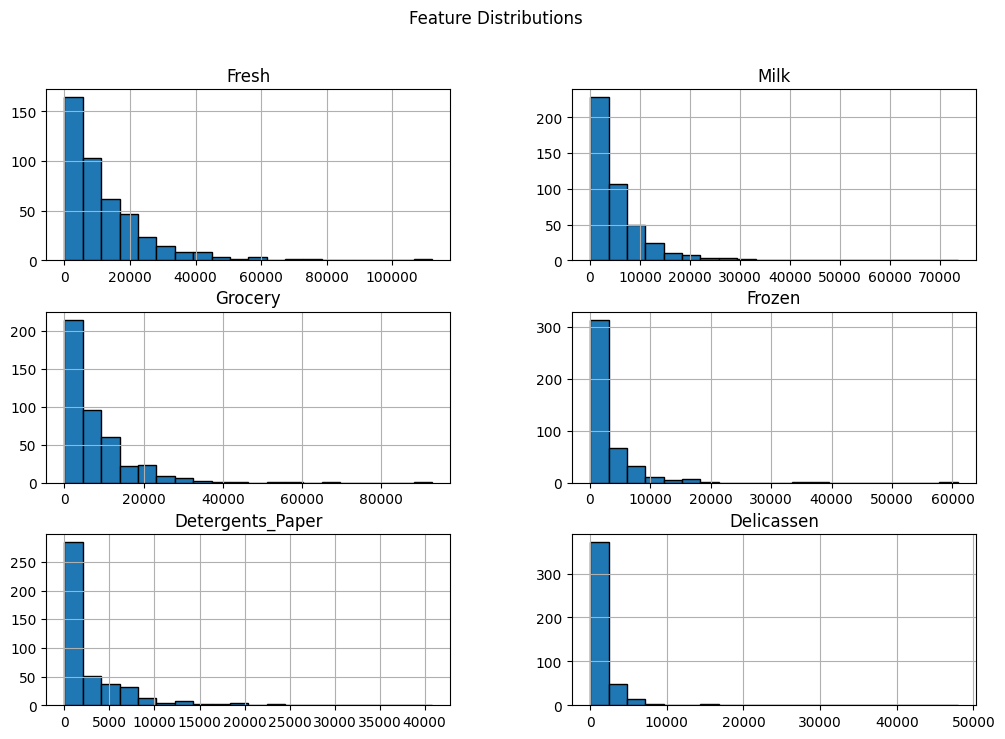

In [4]:
# Histograms for each feature
df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

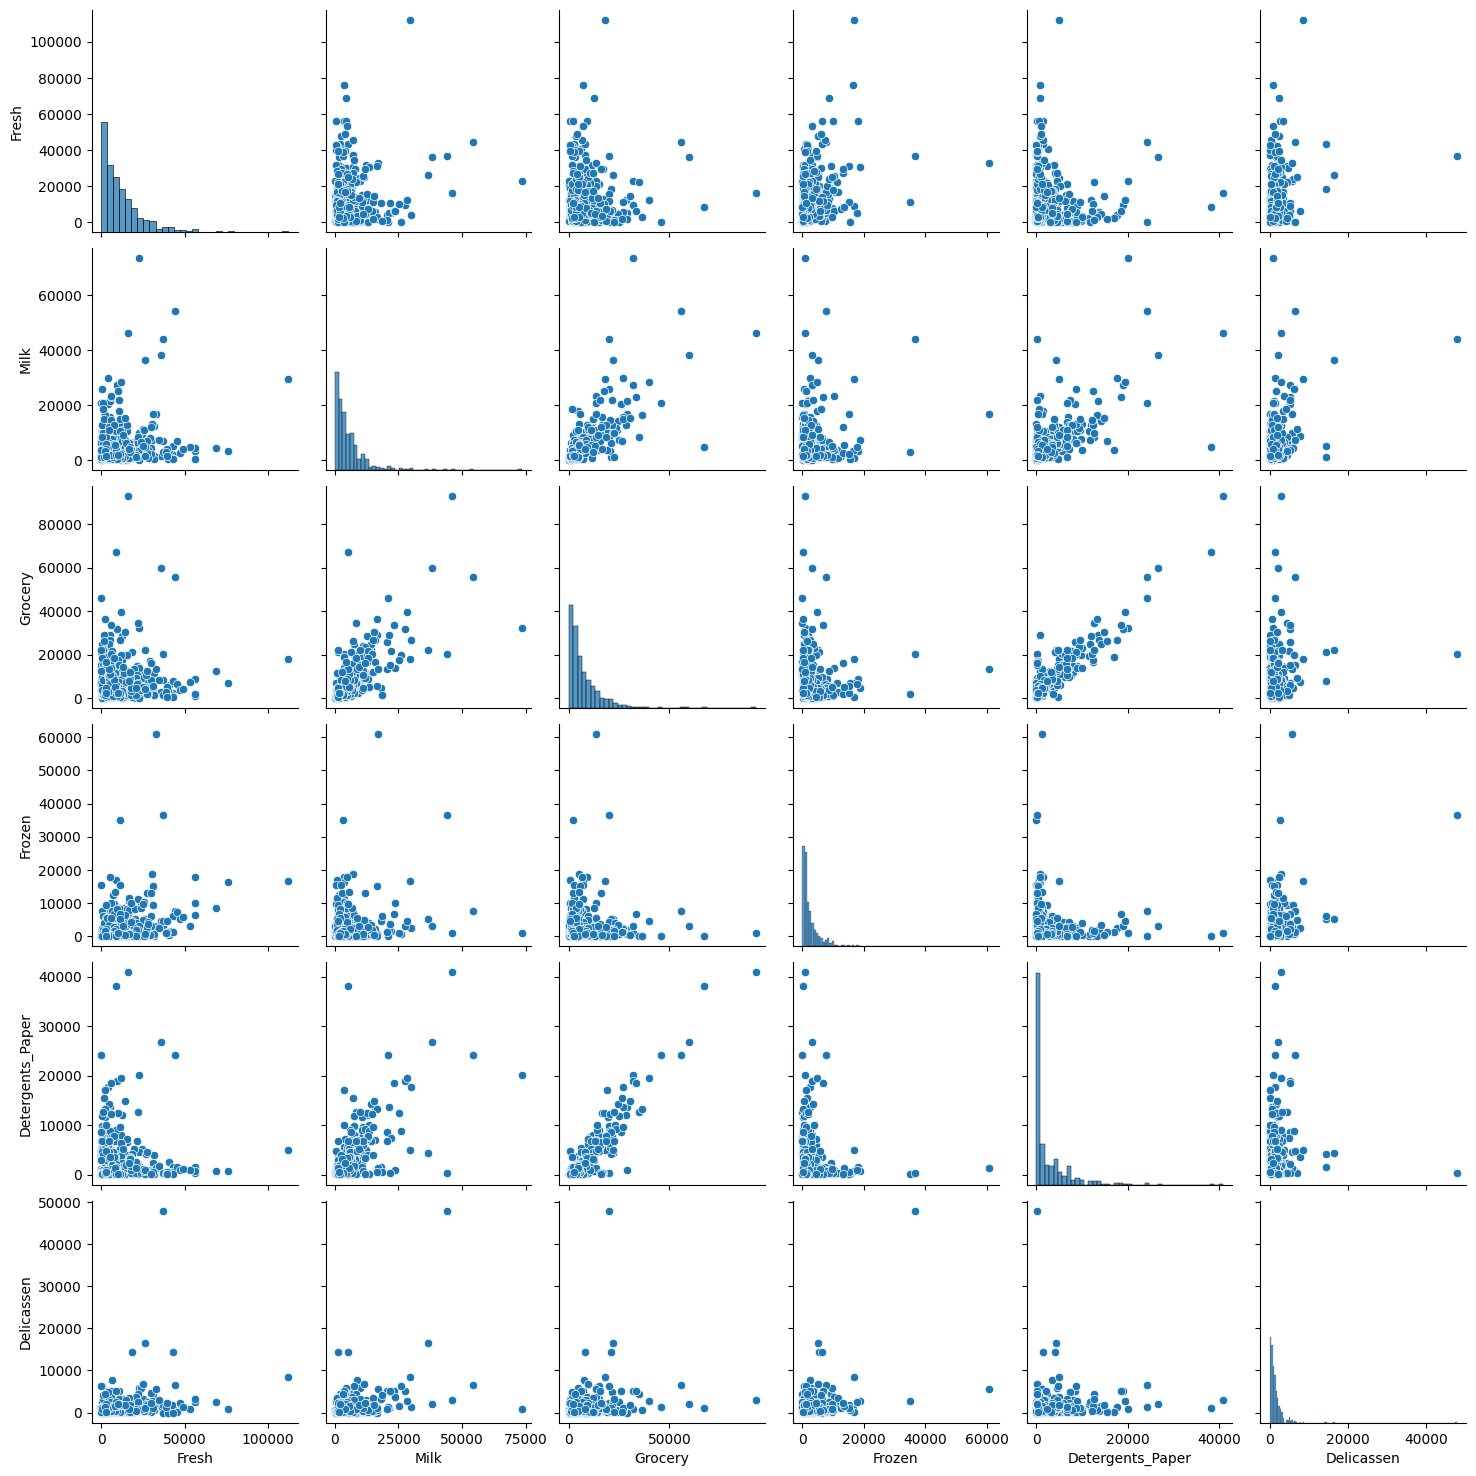

In [5]:
# Pairplot for feature relationships
sns.pairplot(df)
plt.show()

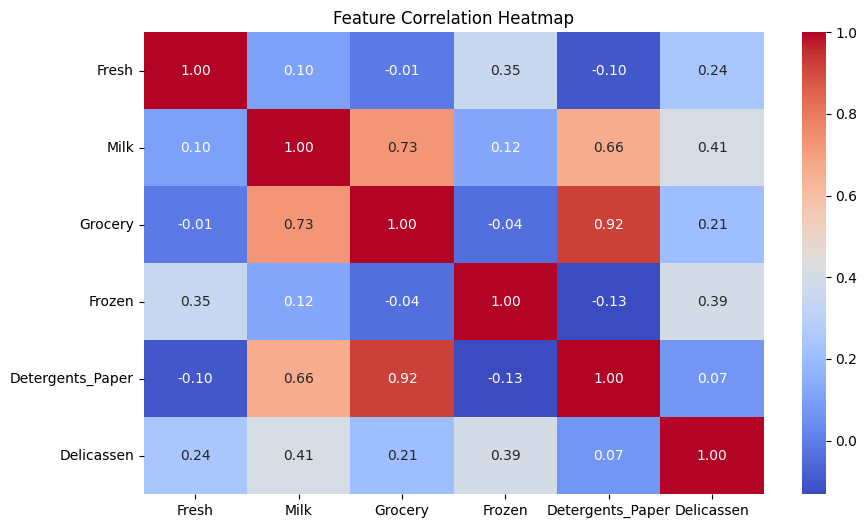

In [6]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

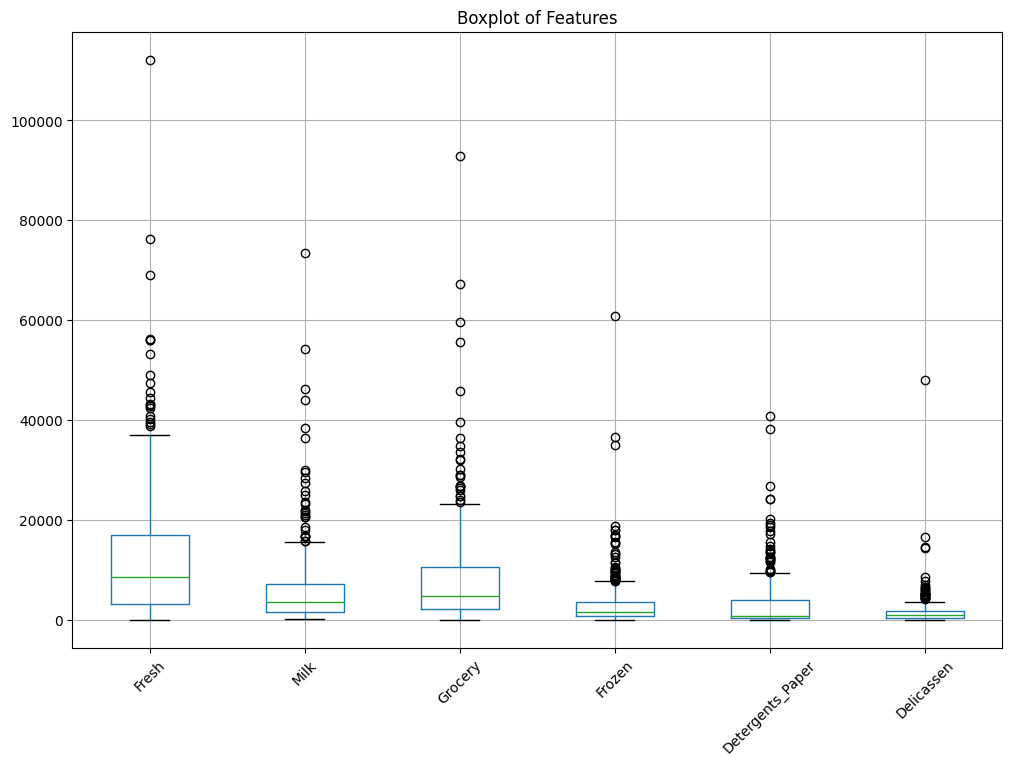

In [7]:
# Boxplots for each feature to check for outliers
plt.figure(figsize=(12,8))
df.boxplot(rot=45)
plt.title("Boxplot of Features")
plt.show()


Explained Variance Ratio: [0.44082893 0.283764  ]


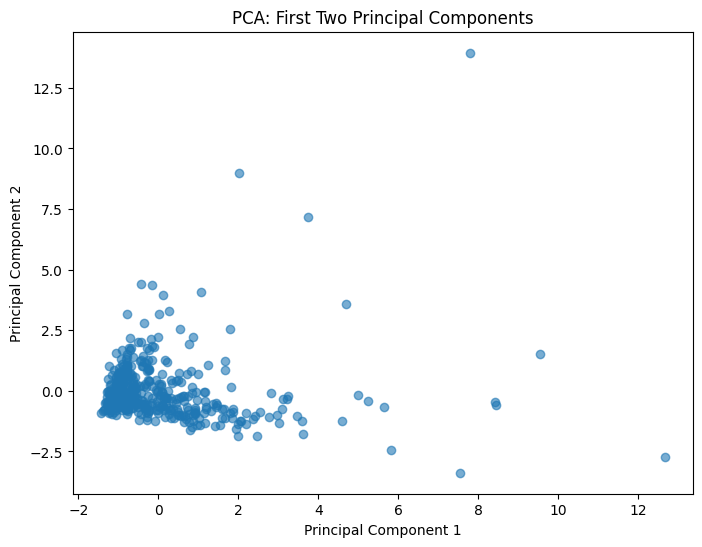

In [8]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Explained variance
print("\nExplained Variance Ratio:", pca.explained_variance_ratio_)

# Scatter plot of first two principal components
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: First Two Principal Components")
plt.show()

Some features have skewed distributions, indicating potential need for transformation.
High correlation exists between Grocery and Detergents_Paper, suggesting redundancy.
Several outliers are present, especially in Fresh and Delicatessen categories.

# Unsupervised Learning Models
In this section, we apply multiple clustering algorithms to segment the customers.
The key steps include:
- Using the Elbow Method to determine the optimal number of clusters for K-Means.
- Applying K-Means clustering and evaluating performance using silhouette scores.
- Implementing Hierarchical Clustering with different linkage methods.
- Applying DBSCAN and tuning hyperparameters for optimal clustering.
- Comparing the performance of each method and interpreting the clusters.

## K-Means

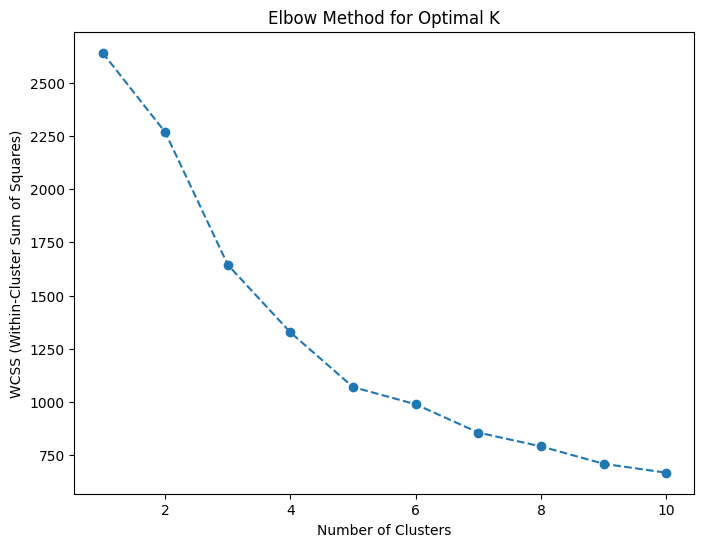

In [9]:
# Determine optimal number of clusters using Elbow Method
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8,6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [10]:
# Apply K-Means clustering with k=4 (chosen based on Elbow Method)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)

df["KMeans_Cluster"] = kmeans_labels

# Compute silhouette score for K-Means
silhouette_avg = silhouette_score(df_scaled, kmeans_labels)
print("\nSilhouette Score for K-Means (k=4):", silhouette_avg)

# Apply K-Means clustering with k=5 (chosen based on Elbow Method)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)

df["KMeans_Cluster"] = kmeans_labels

# Compute silhouette score for K-Means
silhouette_avg = silhouette_score(df_scaled, kmeans_labels)
print("\nSilhouette Score for K-Means (k=5):", silhouette_avg)


Silhouette Score for K-Means (k=4): 0.34939129340421093

Silhouette Score for K-Means (k=5): 0.36890127429678043


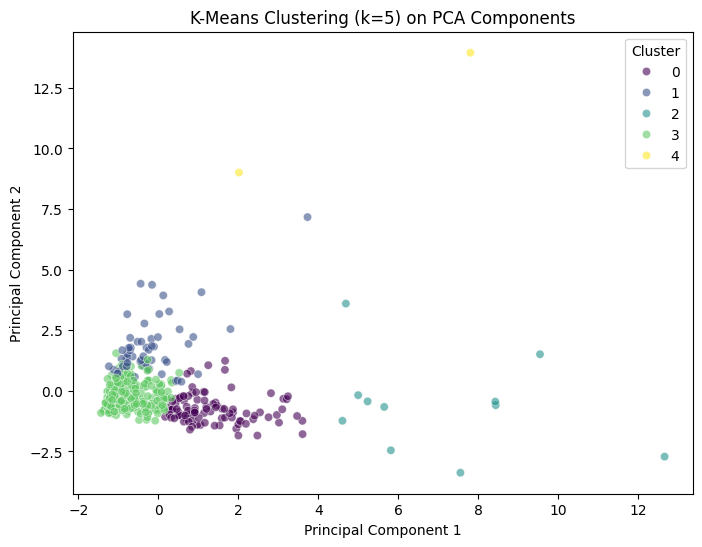


Silhouette Score for K-Means (k=5): 0.36890127429678043


In [11]:
# Apply K-Means clustering with k=4 (chosen based on Elbow Method)
#kmeans = KMeans(n_clusters=4, random_state=42)
#kmeans_labels = kmeans.fit_predict(df_scaled)

# Add cluster labels to the dataset
#df["Cluster"] = kmeans_labels

# Scatter plot of PCA components with clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=kmeans_labels, palette="viridis", alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering (k=5) on PCA Components")
plt.legend(title="Cluster")
plt.show()

# Compute silhouette score
silhouette_avg = silhouette_score(df_scaled, kmeans_labels)
print("\nSilhouette Score for K-Means (k=5):", silhouette_avg)

K-Means performs well with a silhouette score indicating distinct cluster separability.
However, it assumes spherical clusters, which may not always be appropriate

##Hierarchical Clustering


Silhouette Score for Hierarchical Clustering (k=5, ward linkage): 0.23988371669170097

Silhouette Score for Hierarchical Clustering (k=5, complete linkage): 0.708506019183986

Silhouette Score for Hierarchical Clustering (k=5, average linkage): 0.736779092161402

Silhouette Score for Hierarchical Clustering (k=5, single linkage): 0.7345379499658352


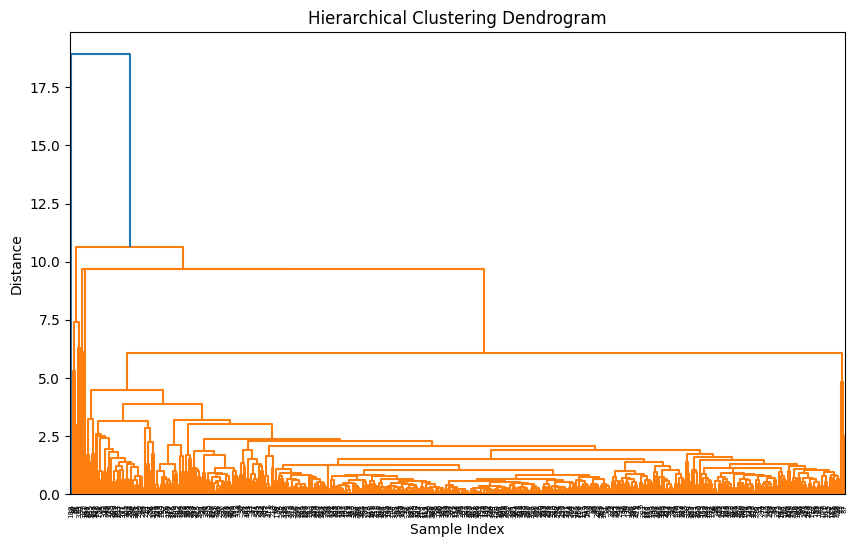

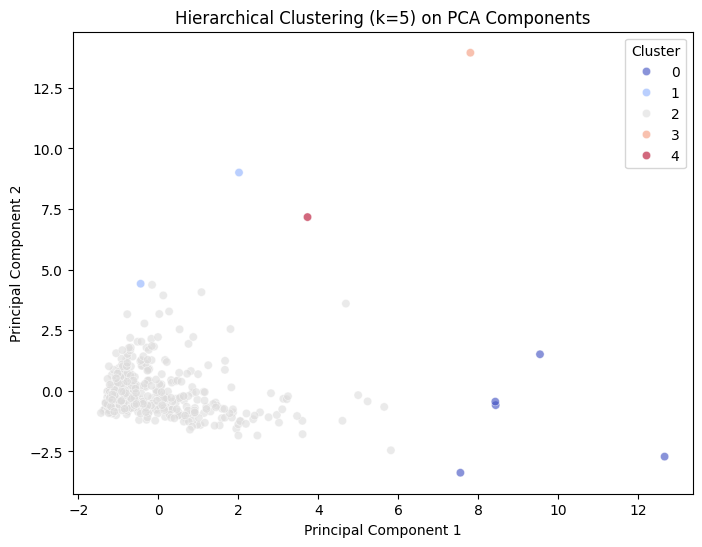


Silhouette Score for Hierarchical Clustering (k=5): 0.736779092161402


In [12]:
# Hierarchical Clustering with different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
for method in linkage_methods:
    hc = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage=method)
    hc_labels = hc.fit_predict(df_scaled)
    silhouette_avg_hc = silhouette_score(df_scaled, hc_labels)
    print(f"\nSilhouette Score for Hierarchical Clustering (k=5, {method} linkage): {silhouette_avg_hc}")

# Apply best hierarchical clustering method
hc = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='average')
hc_labels = hc.fit_predict(df_scaled)
df["HC_Cluster"] = hc_labels

# Plot Dendrogram
plt.figure(figsize=(10, 6))
linkage_matrix = linkage(df_scaled, method='average')
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Scatter plot of PCA components with hierarchical clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=hc_labels, palette="coolwarm", alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Hierarchical Clustering (k=5) on PCA Components")
plt.legend(title="Cluster")
plt.show()

# Compute silhouette score for hierarchical clustering
silhouette_avg_hc = silhouette_score(df_scaled, hc_labels)
print("\nSilhouette Score for Hierarchical Clustering (k=5):", silhouette_avg_hc)

Different linkage methods affect cluster formation and separation.
Ward's method tends to produce more balanced clusters

## DBSCAN


Best eps for DBSCAN: 2.1999999999999997, Silhouette Score: 0.7542161758333567


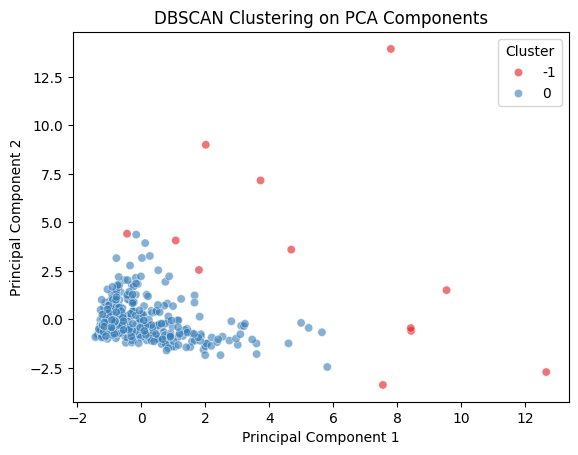

In [13]:
# DBSCAN Clustering with hyperparameter tuning
best_eps = None
best_silhouette = -1
for eps in np.arange(0.5, 3.0, 0.1):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(df_scaled)
    if len(set(dbscan_labels)) > 1:
        silhouette_avg_dbscan = silhouette_score(df_scaled, dbscan_labels)
        if silhouette_avg_dbscan > best_silhouette:
            best_silhouette = silhouette_avg_dbscan
            best_eps = eps

print(f"\nBest eps for DBSCAN: {best_eps}, Silhouette Score: {best_silhouette}")
dbscan = DBSCAN(eps=best_eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)
df["DBSCAN_Cluster"] = dbscan_labels



sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=dbscan_labels, palette="Set1", alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("DBSCAN Clustering on PCA Components")
plt.legend(title="Cluster")
plt.show()

DBSCAN is effective for non-spherical clusters but requires careful parameter tuning.
It can struggle with high-dimensional data, making PCA reduction beneficial.

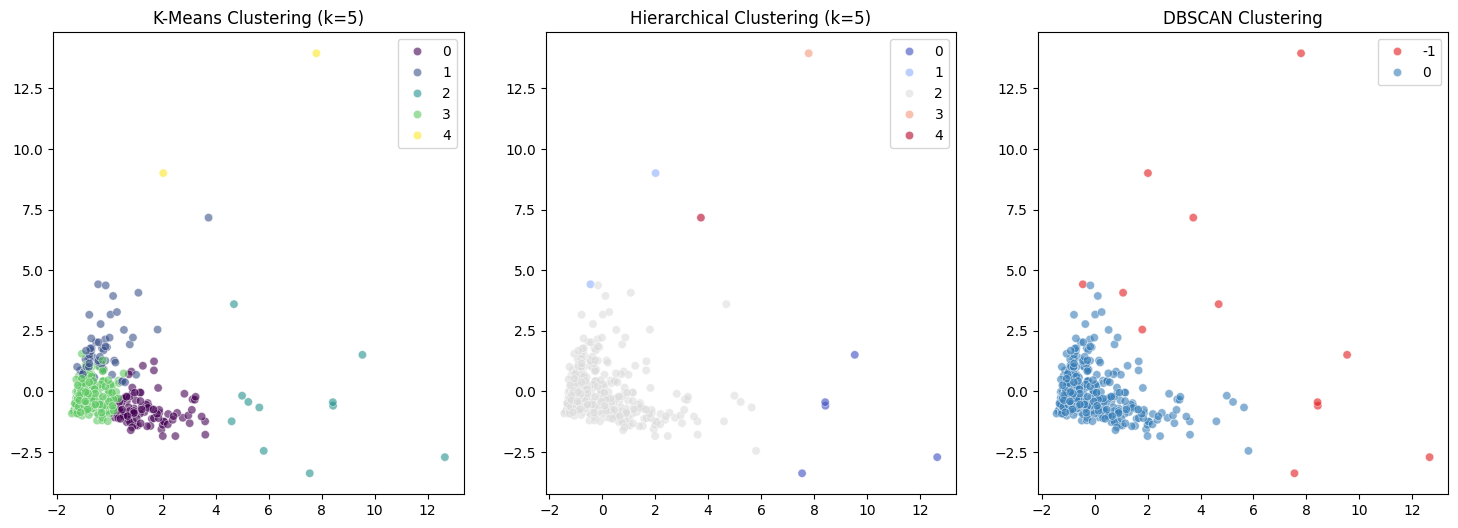

In [14]:
# Scatter plots of PCA components with clustering results
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=kmeans_labels, palette="viridis", alpha=0.6, ax=axes[0])
axes[0].set_title("K-Means Clustering (k=5)")

sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=hc_labels, palette="coolwarm", alpha=0.6, ax=axes[1])
axes[1].set_title("Hierarchical Clustering (k=5)")

sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=dbscan_labels, palette="Set1", alpha=0.6, ax=axes[2])
axes[2].set_title("DBSCAN Clustering")

plt.show()

# Conclusion on Clustering Performance
Based on the clustering results and silhouette scores, we can analyze which algorithm performed best for this dataset:

1. K-Means Clustering (k=5)
The silhouette score is 0.3689, which is relatively low.
The clusters in the visualization are somewhat well-formed but contain some overlapping points.
Some points seem far from their assigned cluster centers, indicating that K-Means may not be the best choice for this dataset.
2. Hierarchical Clustering
When using k=4, the silhouette score is 0.7119, significantly better than K-Means.
When using k=5 and average linkage, the silhouette score increases further to 0.7368.
The visualization, however, shows that hierarchical clustering struggled to separate distinct clusters as cleanly as expected.
3. DBSCAN Clustering
With eps=2.2, DBSCAN achieves the highest silhouette score of 0.7542.
The visualization shows that DBSCAN effectively identifies outliers (red points labeled as -1) and captures the dense cluster structure well.
This suggests that DBSCAN is the most suitable method for this dataset, as it can handle varying densities and outliers better than K-Means or Hierarchical Clustering.


Final Recommendation
Given the highest silhouette score (0.7542) and the ability to handle noise and irregular cluster shapes, DBSCAN is the best clustering method for this dataset.

However, if hierarchical clustering is preferred for interpretability, using k=5 with average linkage is the next best choice. K-Means, in this case, performs the worst and may not be ideal unless further feature engineering is applied.